In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import math
import datetime as dt
from sklearn.metrics import silhouette_score

In [3]:
# Load the CSV files into a list of DataFrames
data_dir = "data/keog/"

os.environ['OMP_NUM_THREADS'] = '1'

PRINT = False
SAVE = False
dataframes = []
dates = []

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, file))
        dataframes.append(df)

In [4]:
heatmaps = []  
heatmaps_imputed = []  

imputer = SimpleImputer(strategy='mean')

for df in dataframes:
    XX, YY = np.meshgrid(df['time_seconds'].unique(), df['gdlat'].unique())
    ZZ = df['blrmvd'].values
    ZZ = np.reshape(ZZ, XX.T.shape).T

    heatmaps.append(ZZ)

    hmi = imputer.fit_transform(ZZ).flatten()
    if hmi.size == 1125:
        heatmaps_imputed.append(hmi)
        first_date = df['datetime'].iloc[0][:10]
        dates.append(first_date)
    else:
        continue

heatmaps_imputed = np.vstack(heatmaps_imputed)

c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [106]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\Maria\anaconda3\envs\gradu\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [59 60 61 62]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [4]:
num_clus = 4
kmeans = KMeans(n_clusters=num_clus)  
labels = kmeans.fit_predict(heatmaps_imputed)

if PRINT:
    for i in range(num_clus):
        cluster_indices = np.where(labels == i)[0]
        print(f"Cluster {i}:")
        for idx in cluster_indices:
            print(f" - Date: {dates[idx]}")

In [5]:
if PRINT:
    for i in range(num_clus):
        cluster_indices = np.where(labels == i)[0]
        n_images = len(cluster_indices)
        print(f"Cluster {i}: {n_images} heatmaps")

        # Setup subplot grid
        n_cols = 5
        n_rows = math.ceil(n_images / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
        axes = axes.flatten()  # Flatten for easy indexing

        for j, idx in enumerate(cluster_indices):
            ax = axes[j]
            ax.imshow(heatmaps[idx], aspect='auto', cmap='viridis')
            ax.set_title(f"Heatmap {idx}\n{dates[idx]}")
            ax.axis('off')  # Hide axes for cleaner layout

        # Hide unused subplots
        for k in range(j+1, len(axes)):
            axes[k].axis('off')

        fig.suptitle(f'Cluster {i}', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title
        plt.show()

In [6]:
if SAVE:
    data = {'dates': dates, 'labels':labels}
    datadf = pd.DataFrame(data, columns=['dates', 'labels'])
    datadf.to_csv(f'data/klusterit/klusteri{k}.csv')
    pd.DataFrame(dates, columns=['date']).to_csv('data/dates.csv', index=False)

if PRINT:
    print(dates)
    print(labels)

In [7]:
ks = [2,3,4,5,6,7,8,9,10,15,25,30]
clusters = {'dates':dates}
for k in ks:
    kmeans = KMeans(n_clusters=k) 
    labels = kmeans.fit_predict(heatmaps_imputed)
    clusters['k'+str(k)] = list(labels)

if SAVE:
    pd.DataFrame(clusters).to_csv('data/clusterdf.csv', index=False)


In [8]:
nruns = 100
jakaumat = {}


for k in ks:
    jakaumat[f'{k}'] = []
    for i in range(nruns):
        kmeans = KMeans(n_clusters=k) 
        labels = kmeans.fit_predict(heatmaps_imputed)
        jak = sorted([len(np.where(labels == j)[0]) for j in range(k)], reverse=True)
        jakaumat[f'{k}'].append(jak)


In [9]:
ykkosluvut = {}
muut = {}

for i in jakaumat:
    ykkosluvut[i] = []
    muut[i] = []
    for run in jakaumat[i]:
        indexit = np.where(np.array(run) == 1)[0]
        ykkosluvut[i].append(len(indexit))
        if len(indexit) > 0:
            muut[i].append(run[:indexit[0]])
        else:
            muut[i].append(run)


In [10]:
for i in ykkosluvut:
    print(i, np.average(ykkosluvut[i]), np.average(ykkosluvut[i])/int(i), sum(ykkosluvut[i]))

2 0.6 0.3 60
3 1.36 0.45333333333333337 136
4 1.9 0.475 190
5 2.45 0.49000000000000005 245
6 3.14 0.5233333333333333 314
7 3.85 0.55 385
8 4.75 0.59375 475
9 5.61 0.6233333333333334 561
10 6.43 0.643 643
15 10.47 0.6980000000000001 1047
25 19.55 0.782 1955
30 24.17 0.8056666666666668 2417


In [11]:
maxit = {'1':[], '2':[], '3':[]}
ykone = {}

for key in muut:
    ykone[key] = []
    for vals in muut[key]:
        ykone[key].append(vals[0])
        for z in range(0,len(vals)):
            try:
                maxit[str(z+1)].append(vals[z])
            except:
                continue


In [12]:
np.average(maxit['1']), np.average(maxit['2']), np.average(maxit['3'])

(101.75416666666666, 23.503243744207598, 9.513444302176696)

In [13]:
np.std(maxit['1']), np.std(maxit['2']), np.std(maxit['3']) 

(20.37086316217902, 6.887265023645238, 6.28995386587707)

In [14]:
for kykoset in ykone:
    print(kykoset, np.average(ykone[kykoset]))

2 128.73
3 122.83
4 114.93
5 109.56
6 105.96
7 102.83
8 102.29
9 99.79
10 95.25
15 90.76
25 76.44
30 71.68


In [15]:
hairiot = [dt.date(2019, 2, 28),
 dt.date(2019, 6, 10),
 dt.date(2019, 6, 13),
 dt.date(2019, 7, 1),
 dt.date(2019, 8, 30),
 dt.date(2019, 9, 2),
 dt.date(2019, 10, 29),
 dt.date(2020, 9, 23),
 dt.date(2021, 1, 15),
 dt.date(2021, 11, 6),
 dt.date(2022, 1, 3),
 dt.date(2022, 1, 4),
 dt.date(2022, 3, 13),
 dt.date(2022, 3, 25),
 dt.date(2023, 2, 27)]



dates = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in dates]


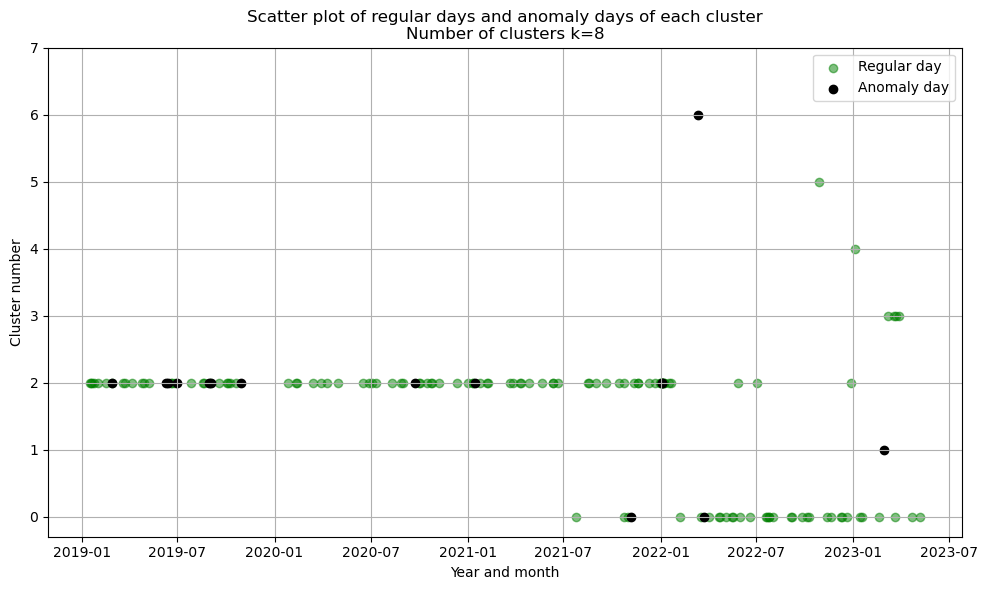

In [16]:
kmeans = KMeans(n_clusters=7)
labels = kmeans.fit_predict(heatmaps_imputed)

fig, ax = plt.subplots(figsize=(10, 6))


anomaly_indices = [i for i, d in enumerate(dates) if d in hairiot]
regular_indices = [i for i, d in enumerate(dates) if d not in hairiot]

ax.scatter(
    [dates[i] for i in regular_indices],
    [labels[i] for i in regular_indices],
    color='green',
    alpha=0.5,
    label='Regular day'
)

ax.scatter(
    [dates[i] for i in anomaly_indices],
    [labels[i] for i in anomaly_indices],
    color='black',
    alpha=1.0,
    label='Anomaly day'
)


ax.grid(True)
ax.legend()
ax.set_yticks(range(0, 8))
plt.title('Scatter plot of regular days and anomaly days of each cluster\nNumber of clusters k=8')
plt.ylabel('Cluster number')
plt.xlabel('Year and month')
plt.tight_layout()
plt.show()

In [12]:
labeldf = pd.read_csv('data/clusterdf.csv', sep=',')
labeldf


,dates,k2,k3,k4,k5,k6,k7,k8,k9,k10,k15,k25,k30
0,2019-01-16,1,0,0,0,1,1,6,1,1,2,1,23
1,2019-01-19,1,0,0,0,1,1,6,1,1,2,1,1
2,2019-01-21,1,0,0,0,1,1,0,1,1,2,1,23
3,2019-01-24,1,0,0,0,1,1,0,1,1,2,1,23
4,2019-01-31,1,0,0,0,1,1,0,1,1,2,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2023-03-22,0,0,3,0,3,0,1,0,5,14,13,11
135,2023-03-29,0,0,3,0,3,0,1,0,8,5,11,0
136,2023-04-21,0,0,3,0,3,0,1,8,3,3,20,28
137,2023-05-07,0,0,3,0,3,0,1,8,3,11,8,29


In [ ]:
scores = []

for kid in [2,3,4,5,6,7,8,9,10,15,25,30]:

    scores.append(silhouette_score(heatmaps_imputed, labeldf[f'k{kid}']))

scores

[0.30551082333563434,
 0.5642697897404386,
 0.3255067784248975,
 0.29100982178801804,
 0.299259259500893,
 0.29166492029756985,
 0.09580943827706992,
 0.21516745413193702,
 0.06018176504647297,
 0.27341670921476185,
 0.0677150391276323,
 -0.08622883137312072]

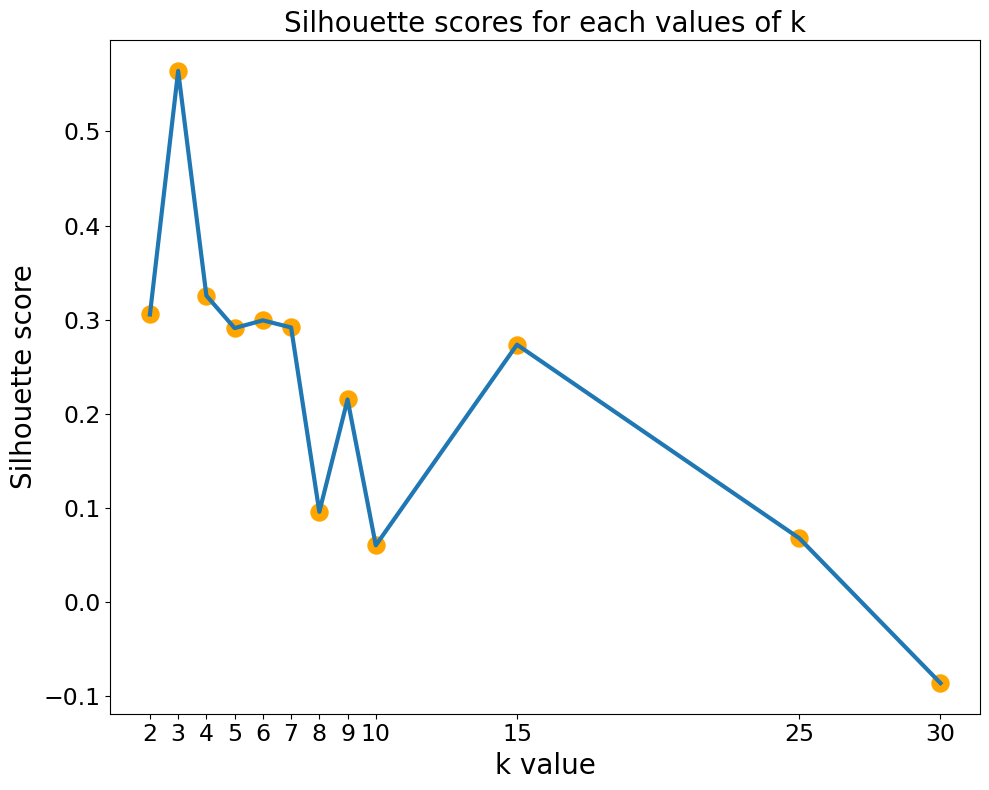

In [ ]:
plt.figure(figsize=(10,8))
plt.plot([2,3,4,5,6,7,8,9,10,15,25,30], scores, linewidth=3)
plt.scatter([2,3,4,5,6,7,8,9,10,15,25,30], scores, c='orange', s=150)

plt.title('Silhouette scores for each values of k', fontsize=20)
plt.xlabel('k value', fontsize=20)
plt.ylabel('Silhouette score', fontsize=20)

plt.xticks([2,3,4,5,6,7,8,9,10,15,25,30], fontsize=17)
plt.yticks(fontsize=17)

plt.tight_layout()
#plt.savefig('data/sscore.png')
plt.show()






